In [2]:
#dataset
import os
import zipfile
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical

def load_dataset(zip_file_path):
    # Extract ZIP file to the 'dataset' folder
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('dataset')
    
    # Verify the base directory after extraction
    base_dir = 'dataset/Brain-Tumor-Classification-DataSet-master'
    train_dir = os.path.join(base_dir, 'Training')
    test_dir = os.path.join(base_dir, 'Testing')
    
    # Check if base directory exists
    if not os.path.exists(train_dir) or not os.path.exists(test_dir):
        print(f"Error: Training or Testing directory does not exist in {base_dir}.")
        return None, None, None
    
    categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
    
    def load_images_from_dir(directory):
        images = []
        labels = []
        for label, category in enumerate(categories):
            category_path = os.path.join(directory, category)
            print(f"Checking category path: {category_path}")  # Debugging path check
            if not os.path.exists(category_path):
                print(f"Category path does not exist: {category_path}")
                continue
            for file_name in os.listdir(category_path):
                img_path = os.path.join(category_path, file_name)
                # Load images, resize to (28, 28), and convert to grayscale
                img = load_img(img_path, color_mode='grayscale', target_size=(28, 28))
                img_array = img_to_array(img)
                images.append(img_array)
                labels.append(label)
        return np.array(images), np.array(labels)
    
    # Load training and testing data
    trainX, trainY = load_images_from_dir(train_dir)
    testX, testY = load_images_from_dir(test_dir)
    
    # Check if images were loaded
    if len(trainX) == 0 or len(testX) == 0:
        print("Error: No images were loaded. Please check the directory structure.")
        return None, None, None

    # Normalize pixel values to [0, 1]
    trainX = trainX / 255.0
    testX = testX / 255.0
    
    # One-hot encode labels (for multi-class classification)
    trainY = to_categorical(trainY, num_classes=len(categories))
    testY = to_categorical(testY, num_classes=len(categories))
    
    # Data augmentation for training set
    train_datagen = ImageDataGenerator(
        rotation_range=10,       # Random rotation
        width_shift_range=0.1,   # Random horizontal shift
        height_shift_range=0.1,  # Random vertical shift
        zoom_range=0.1           # Random zoom
    )
    
    # Apply data augmentation to training data
    train_generator = train_datagen.flow(trainX, trainY, batch_size=32)
    
    return train_generator, testX, testY

# Example usage:
zip_file_path = 'archive (17).zip'
train_generator, testX, testY = load_dataset(zip_file_path)

if train_generator is not None:
    print("Dataset loaded successfully!")


Checking category path: dataset/Brain-Tumor-Classification-DataSet-master\Training\glioma_tumor
Checking category path: dataset/Brain-Tumor-Classification-DataSet-master\Training\meningioma_tumor
Checking category path: dataset/Brain-Tumor-Classification-DataSet-master\Training\no_tumor
Checking category path: dataset/Brain-Tumor-Classification-DataSet-master\Training\pituitary_tumor
Checking category path: dataset/Brain-Tumor-Classification-DataSet-master\Testing\glioma_tumor
Checking category path: dataset/Brain-Tumor-Classification-DataSet-master\Testing\meningioma_tumor
Checking category path: dataset/Brain-Tumor-Classification-DataSet-master\Testing\no_tumor
Checking category path: dataset/Brain-Tumor-Classification-DataSet-master\Testing\pituitary_tumor
Dataset loaded successfully!


In [6]:
#auto-encoder
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def load_dataset(zip_file_path):
    # Extract ZIP file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('dataset')
    
    # Load images and labels
    images_dir = 'dataset/Brain-Tumor-Classification-DataSet-master'
    images = []
    labels = []
    categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
    
    for label, category in enumerate(categories):
        category_path = os.path.join(images_dir, 'Training', category)
        for file_name in os.listdir(category_path):
            img_path = os.path.join(category_path, file_name)
            img = load_img(img_path, color_mode='grayscale', target_size=(28, 28))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    
    # Convert to numpy arrays and reshape
    images = np.array(images).reshape((-1, 28, 28, 1))
    labels = np.array(labels)
    
    # One-hot encode labels (for multi-class classification)
    labels = to_categorical(labels, num_classes=len(categories))
    
    # Split dataset into training and testing sets (e.g., 80% train, 20% test)
    trainX, testX, trainY, testY = train_test_split(images, labels, test_size=0.2, random_state=42)
    return trainX, trainY, testX, testY

# Load the dataset
zip_file_path = r"C:\Users\91817\Downloads\archive (15).zip"
trainX, trainY, testX, testY = load_dataset(zip_file_path)

# Normalize the images
trainX = trainX.astype('float32') / 255.0
testX = testX.astype('float32') / 255.0

# Build the autoencoder
input_img = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(trainX, trainX, epochs=50, batch_size=64, shuffle=True, validation_data=(testX, testX))

# Encoder model to get compressed features
encoder = models.Model(input_img, encoded)

# Get the encoded/compressed features
trainX_encoded = encoder.predict(trainX)
testX_encoded = encoder.predict(testX)

# Flatten the encoded features for DNN input
trainX_flat = trainX_encoded.reshape(trainX_encoded.shape[0], -1)
testX_flat = testX_encoded.reshape(testX_encoded.shape[0], -1)

# Build the DNN for multi-class classification
dnn = models.Sequential()
dnn.add(layers.Dense(128, activation='relu', input_shape=(trainX_flat.shape[1],)))
dnn.add(layers.Dropout(0.5))
dnn.add(layers.Dense(64, activation='relu'))
dnn.add(layers.Dropout(0.5))
dnn.add(layers.Dense(4, activation='softmax'))  # Change to 4 classes and softmax

# Compile DNN with categorical cross-entropy for multi-class classification
dnn.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the DNN classifier
dnn.fit(trainX_flat, trainY, epochs=20, batch_size=64, validation_data=(testX_flat, testY))

# Evaluate the model
loss, accuracy = dnn.evaluate(testX_flat, testY)
print(f'Test Accuracy: {accuracy*100:.2f}%')



Epoch 1/50
36/36 [==============================] - 4s 62ms/step - loss: 0.5190 - val_loss: 0.4126
Epoch 2/50
36/36 [==============================] - 2s 52ms/step - loss: 0.3983 - val_loss: 0.3893
Epoch 3/50
36/36 [==============================] - 2s 53ms/step - loss: 0.3895 - val_loss: 0.3851
Epoch 4/50
36/36 [==============================] - 2s 52ms/step - loss: 0.3862 - val_loss: 0.3830
Epoch 5/50
36/36 [==============================] - 2s 52ms/step - loss: 0.3841 - val_loss: 0.3810
Epoch 6/50
36/36 [==============================] - 2s 52ms/step - loss: 0.3823 - val_loss: 0.3791
Epoch 7/50
36/36 [==============================] - 2s 52ms/step - loss: 0.3809 - val_loss: 0.3777
Epoch 8/50
36/36 [==============================] - 2s 54ms/step - loss: 0.3798 - val_loss: 0.3772
Epoch 9/50
36/36 [==============================] - 2s 53ms/step - loss: 0.3786 - val_loss: 0.3756
Epoch 10/50
36/36 [==============================] - 2s 52ms/step - loss: 0.3778 - val_loss: 0.3746
Epoch 11

In [7]:
#sparse-autoencoder
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def load_dataset(zip_file_path):
    # Extract ZIP file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('dataset')
    
    # Load images and labels
    images_dir = 'dataset/Brain-Tumor-Classification-DataSet-master'
    images = []
    labels = []
    categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
    
    for label, category in enumerate(categories):
        category_path = os.path.join(images_dir, 'Training', category)
        for file_name in os.listdir(category_path):
            img_path = os.path.join(category_path, file_name)
            img = load_img(img_path, color_mode='grayscale', target_size=(28, 28))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    
    # Convert to numpy arrays and reshape
    images = np.array(images).reshape((-1, 28, 28, 1))
    labels = np.array(labels)
    
    # One-hot encode labels (for multi-class classification)
    labels = to_categorical(labels, num_classes=len(categories))
    
    # Split dataset into training and testing sets (e.g., 80% train, 20% test)
    trainX, testX, trainY, testY = train_test_split(images, labels, test_size=0.2, random_state=42)
    return trainX, trainY, testX, testY

# Load the dataset
zip_file_path = r"C:\Users\91817\Downloads\archive (15).zip"
trainX, trainY, testX, testY = load_dataset(zip_file_path)

# Normalize the images
trainX = trainX.astype('float32') / 255.0
testX = testX.astype('float32') / 255.0

# Build the sparse autoencoder
input_img = layers.Input(shape=(28, 28, 1))

# Encoder with sparsity (L1 regularization)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                  activity_regularizer=tf.keras.regularizers.l1(10e-5))(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                  activity_regularizer=tf.keras.regularizers.l1(10e-5))(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Compile the sparse autoencoder
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the sparse autoencoder
autoencoder.fit(trainX, trainX, epochs=50, batch_size=64, shuffle=True, validation_data=(testX, testX))

# Encoder model to get compressed features
encoder = models.Model(input_img, encoded)

# Get the encoded/compressed features
trainX_encoded = encoder.predict(trainX)
testX_encoded = encoder.predict(testX)

# Flatten the encoded features for DNN input
trainX_flat = trainX_encoded.reshape(trainX_encoded.shape[0], -1)
testX_flat = testX_encoded.reshape(testX_encoded.shape[0], -1)

# Build the DNN for multi-class classification
dnn = models.Sequential()
dnn.add(layers.Dense(128, activation='relu', input_shape=(trainX_flat.shape[1],)))
dnn.add(layers.Dropout(0.5))
dnn.add(layers.Dense(64, activation='relu'))
dnn.add(layers.Dropout(0.5))
dnn.add(layers.Dense(4, activation='softmax'))  # For multi-class classification

# Compile DNN with categorical cross-entropy for multi-class classification
dnn.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the DNN classifier
dnn.fit(trainX_flat, trainY, epochs=20, batch_size=64, validation_data=(testX_flat, testY))

# Evaluate the model
loss, accuracy = dnn.evaluate(testX_flat, testY)
print(f'Test Accuracy: {accuracy*100:.2f}%')


Epoch 1/50
36/36 [==============================] - 5s 75ms/step - loss: 0.5627 - val_loss: 0.4527
Epoch 2/50
36/36 [==============================] - 2s 63ms/step - loss: 0.4297 - val_loss: 0.4132
Epoch 3/50
36/36 [==============================] - 2s 63ms/step - loss: 0.4097 - val_loss: 0.4022
Epoch 4/50
36/36 [==============================] - 2s 63ms/step - loss: 0.4009 - val_loss: 0.3945
Epoch 5/50
36/36 [==============================] - 2s 62ms/step - loss: 0.3944 - val_loss: 0.3896
Epoch 6/50
36/36 [==============================] - 2s 62ms/step - loss: 0.3908 - val_loss: 0.3870
Epoch 7/50
36/36 [==============================] - 2s 63ms/step - loss: 0.3886 - val_loss: 0.3852
Epoch 8/50
36/36 [==============================] - 2s 64ms/step - loss: 0.3871 - val_loss: 0.3840
Epoch 9/50
36/36 [==============================] - 2s 63ms/step - loss: 0.3859 - val_loss: 0.3828
Epoch 10/50
36/36 [==============================] - 2s 62ms/step - loss: 0.3849 - val_loss: 0.3821
Epoch 11/

In [8]:
#de-noising iamges
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def load_dataset(zip_file_path):
    # Extract ZIP file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('dataset')
    
    # Load images and labels
    images_dir = 'dataset/Brain-Tumor-Classification-DataSet-master'
    images = []
    labels = []
    categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
    
    for label, category in enumerate(categories):
        category_path = os.path.join(images_dir, 'Training', category)
        for file_name in os.listdir(category_path):
            img_path = os.path.join(category_path, file_name)
            img = load_img(img_path, color_mode='grayscale', target_size=(28, 28))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    
    # Convert to numpy arrays and reshape
    images = np.array(images).reshape((-1, 28, 28, 1))
    labels = np.array(labels)
    
    # One-hot encode labels (for multi-class classification)
    labels = to_categorical(labels, num_classes=len(categories))
    
    # Split dataset into training and testing sets (e.g., 80% train, 20% test)
    trainX, testX, trainY, testY = train_test_split(images, labels, test_size=0.2, random_state=42)
    return trainX, trainY, testX, testY

# Load the dataset
zip_file_path = r"C:\Users\91817\Downloads\archive (15).zip"
trainX, trainY, testX, testY = load_dataset(zip_file_path)

# Normalize the images
trainX = trainX.astype('float32') / 255.0
testX = testX.astype('float32') / 255.0

# Add random noise to the images (Gaussian noise)
def add_noise(images, noise_factor=0.3):
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, 0., 1.)  # Clip to ensure pixel values are between 0 and 1
    return noisy_images

trainX_noisy = add_noise(trainX)
testX_noisy = add_noise(testX)

# Build the denoising autoencoder
input_img = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Compile the denoising autoencoder
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the denoising autoencoder with noisy images as input and clean images as target
autoencoder.fit(trainX_noisy, trainX, epochs=50, batch_size=64, shuffle=True, validation_data=(testX_noisy, testX))

# Encoder model to get compressed features
encoder = models.Model(input_img, encoded)

# Get the encoded/compressed features
trainX_encoded = encoder.predict(trainX)
testX_encoded = encoder.predict(testX)

# Flatten the encoded features for DNN input
trainX_flat = trainX_encoded.reshape(trainX_encoded.shape[0], -1)
testX_flat = testX_encoded.reshape(testX_encoded.shape[0], -1)

# Build the DNN for multi-class classification
dnn = models.Sequential()
dnn.add(layers.Dense(128, activation='relu', input_shape=(trainX_flat.shape[1],)))
dnn.add(layers.Dropout(0.5))
dnn.add(layers.Dense(64, activation='relu'))
dnn.add(layers.Dropout(0.5))
dnn.add(layers.Dense(4, activation='softmax'))  # For multi-class classification

# Compile DNN with categorical cross-entropy for multi-class classification
dnn.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the DNN classifier
dnn.fit(trainX_flat, trainY, epochs=20, batch_size=64, validation_data=(testX_flat, testY))

# Evaluate the model
loss, accuracy = dnn.evaluate(testX_flat, testY)
print(f'Test Accuracy: {accuracy*100:.2f}%')


Epoch 1/50
36/36 [==============================] - 4s 65ms/step - loss: 0.5271 - val_loss: 0.4292
Epoch 2/50
36/36 [==============================] - 2s 56ms/step - loss: 0.4124 - val_loss: 0.3994
Epoch 3/50
36/36 [==============================] - 2s 55ms/step - loss: 0.3997 - val_loss: 0.3952
Epoch 4/50
36/36 [==============================] - 2s 55ms/step - loss: 0.3969 - val_loss: 0.3934
Epoch 5/50
36/36 [==============================] - 2s 52ms/step - loss: 0.3954 - val_loss: 0.3922
Epoch 6/50
36/36 [==============================] - 2s 53ms/step - loss: 0.3943 - val_loss: 0.3915
Epoch 7/50
36/36 [==============================] - 2s 55ms/step - loss: 0.3933 - val_loss: 0.3904
Epoch 8/50
36/36 [==============================] - 2s 55ms/step - loss: 0.3928 - val_loss: 0.3897
Epoch 9/50
36/36 [==============================] - 2s 57ms/step - loss: 0.3920 - val_loss: 0.3906
Epoch 10/50
36/36 [==============================] - 2s 54ms/step - loss: 0.3918 - val_loss: 0.3891
Epoch 11/

Epoch 1/50
36/36 [==============================] - 4s 59ms/step - loss: 0.5152 - val_loss: 0.4204
Epoch 2/50
36/36 [==============================] - 2s 50ms/step - loss: 0.4068 - val_loss: 0.3975
Epoch 3/50
36/36 [==============================] - 2s 49ms/step - loss: 0.3983 - val_loss: 0.3945
Epoch 4/50
36/36 [==============================] - 2s 50ms/step - loss: 0.3961 - val_loss: 0.3926
Epoch 5/50
36/36 [==============================] - 2s 50ms/step - loss: 0.3945 - val_loss: 0.3922
Epoch 6/50
36/36 [==============================] - 2s 49ms/step - loss: 0.3936 - val_loss: 0.3906
Epoch 7/50
36/36 [==============================] - 2s 49ms/step - loss: 0.3929 - val_loss: 0.3900
Epoch 8/50
36/36 [==============================] - 2s 50ms/step - loss: 0.3920 - val_loss: 0.3897
Epoch 9/50
36/36 [==============================] - 2s 50ms/step - loss: 0.3914 - val_loss: 0.3889
Epoch 10/50
36/36 [==============================] - 2s 51ms/step - loss: 0.3913 - val_loss: 0.3883
Epoch 11/

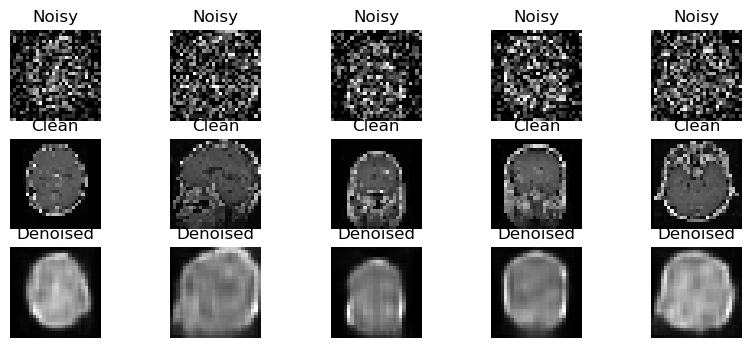

18/18 [==============================] - 0s 3ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.92      0.75       179
           1       0.64      0.22      0.33       169
           2       0.61      0.77      0.68        70
           3       0.87      0.94      0.90       156

    accuracy                           0.70       574
   macro avg       0.69      0.71      0.67       574
weighted avg       0.70      0.70      0.66       574

18/18 [==============================] - 0s 3ms/step


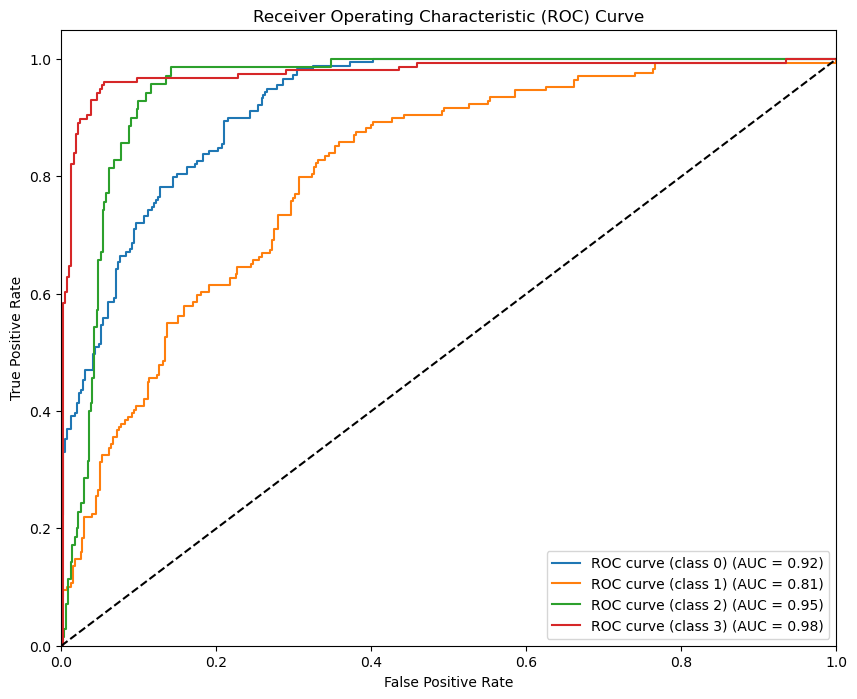

In [9]:
#de-noising images
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import label_binarize

def load_dataset(zip_file_path):
    # Extract ZIP file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('dataset')
    
    # Load images and labels
    images_dir = 'dataset/Brain-Tumor-Classification-DataSet-master'
    images = []
    labels = []
    categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
    
    for label, category in enumerate(categories):
        category_path = os.path.join(images_dir, 'Training', category)
        for file_name in os.listdir(category_path):
            img_path = os.path.join(category_path, file_name)
            img = load_img(img_path, color_mode='grayscale', target_size=(28, 28))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    
    # Convert to numpy arrays and reshape
    images = np.array(images).reshape((-1, 28, 28, 1))
    labels = np.array(labels)
    
    # One-hot encode labels (for multi-class classification)
    labels = to_categorical(labels, num_classes=len(categories))
    
    # Split dataset into training and testing sets (e.g., 80% train, 20% test)
    trainX, testX, trainY, testY = train_test_split(images, labels, test_size=0.2, random_state=42)
    return trainX, trainY, testX, testY

# Load the dataset
zip_file_path = r"C:\Users\91817\Downloads\archive (15).zip"
trainX, trainY, testX, testY = load_dataset(zip_file_path)

# Normalize the images
trainX = trainX.astype('float32') / 255.0
testX = testX.astype('float32') / 255.0

# Add random noise to the images (Gaussian noise)
def add_noise(images, noise_factor=0.3):
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, 0., 1.)  # Clip to ensure pixel values are between 0 and 1
    return noisy_images

trainX_noisy = add_noise(trainX)
testX_noisy = add_noise(testX)

# Build the denoising autoencoder
input_img = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Compile the denoising autoencoder
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the denoising autoencoder with noisy images as input and clean images as target
autoencoder.fit(trainX_noisy, trainX, epochs=50, batch_size=64, shuffle=True, validation_data=(testX_noisy, testX))

# Encoder model to get compressed features
encoder = models.Model(input_img, encoded)

# Get the encoded/compressed features
trainX_encoded = encoder.predict(trainX)
testX_encoded = encoder.predict(testX)

# Flatten the encoded features for DNN input
trainX_flat = trainX_encoded.reshape(trainX_encoded.shape[0], -1)
testX_flat = testX_encoded.reshape(testX_encoded.shape[0], -1)

# Build the DNN for multi-class classification
dnn = models.Sequential()
dnn.add(layers.Dense(128, activation='relu', input_shape=(trainX_flat.shape[1],)))
dnn.add(layers.Dropout(0.5))
dnn.add(layers.Dense(64, activation='relu'))
dnn.add(layers.Dropout(0.5))
dnn.add(layers.Dense(4, activation='softmax'))  # For multi-class classification

# Compile DNN with categorical cross-entropy for multi-class classification
dnn.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the DNN classifier
dnn.fit(trainX_flat, trainY, epochs=20, batch_size=64, validation_data=(testX_flat, testY))

# Evaluate the model
loss, accuracy = dnn.evaluate(testX_flat, testY)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# 1. Display Original, Noisy, and Denoised images
def display_images(noisy, clean, denoised, n=5):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        # Noisy images
        plt.subplot(3, n, i + 1)
        plt.imshow(noisy[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title("Noisy")

        # Clean images
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(clean[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title("Clean")

        # Denoised images
        plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(denoised[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title("Denoised")

    plt.show()

# Get reconstructed images
denoised_images = autoencoder.predict(testX_noisy)

# Display first 5 images before and after denoising
display_images(testX_noisy, testX, denoised_images)

# 2. Classification Report
testY_pred = np.argmax(dnn.predict(testX_flat), axis=1)
testY_true = np.argmax(testY, axis=1)
print("\nClassification Report:\n", classification_report(testY_true, testY_pred))

# 3. ROC Curve
fpr = {}
tpr = {}
roc_auc = {}

# Binarize labels for ROC
testY_bin = label_binarize(testY_true, classes=[0, 1, 2, 3])

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(testY_bin[:, i], dnn.predict(testX_flat)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Epoch 1/10
36/36 [==============================] - 150s 4s/step - loss: 1.4437 - accuracy: 0.2896 - val_loss: 1.2841 - val_accuracy: 0.4338
Epoch 2/10
36/36 [==============================] - 144s 4s/step - loss: 1.2927 - accuracy: 0.3589 - val_loss: 1.2400 - val_accuracy: 0.5767
Epoch 3/10
36/36 [==============================] - 136s 4s/step - loss: 1.2522 - accuracy: 0.4094 - val_loss: 1.1962 - val_accuracy: 0.5505
Epoch 4/10
36/36 [==============================] - 134s 4s/step - loss: 1.2209 - accuracy: 0.4395 - val_loss: 1.1575 - val_accuracy: 0.5749
Epoch 5/10
36/36 [==============================] - 138s 4s/step - loss: 1.1829 - accuracy: 0.4765 - val_loss: 1.1385 - val_accuracy: 0.5836
Epoch 6/10
36/36 [==============================] - 139s 4s/step - loss: 1.1615 - accuracy: 0.4961 - val_loss: 1.1041 - val_accuracy: 0.6010
Epoch 7/10
36/36 [==============================] - 138s 4s/step - loss: 1.1333 - accuracy: 0.5314 - val_loss: 1.0784 - val_accuracy: 0.6237
Epoch 8/10
36

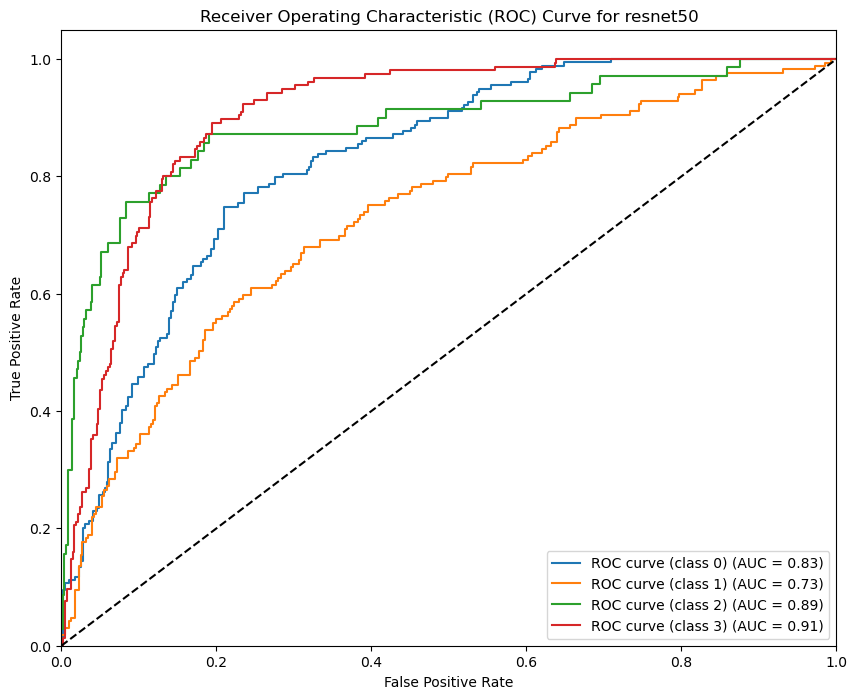

Epoch 1/10
36/36 [==============================] - 312s 9s/step - loss: 1.3343 - accuracy: 0.3741 - val_loss: 1.1507 - val_accuracy: 0.5557
Epoch 2/10
36/36 [==============================] - 320s 9s/step - loss: 1.0749 - accuracy: 0.5819 - val_loss: 0.9799 - val_accuracy: 0.6481
Epoch 3/10
36/36 [==============================] - 308s 9s/step - loss: 0.9504 - accuracy: 0.6533 - val_loss: 0.8616 - val_accuracy: 0.6794
Epoch 4/10
36/36 [==============================] - 318s 9s/step - loss: 0.8410 - accuracy: 0.6960 - val_loss: 0.7868 - val_accuracy: 0.7282
Epoch 5/10
36/36 [==============================] - 303s 8s/step - loss: 0.7610 - accuracy: 0.7326 - val_loss: 0.7378 - val_accuracy: 0.7091
Epoch 6/10
36/36 [==============================] - 307s 9s/step - loss: 0.7131 - accuracy: 0.7448 - val_loss: 0.6842 - val_accuracy: 0.7230
Epoch 7/10
36/36 [==============================] - 308s 9s/step - loss: 0.6705 - accuracy: 0.7639 - val_loss: 0.6565 - val_accuracy: 0.7544
Epoch 8/10
36

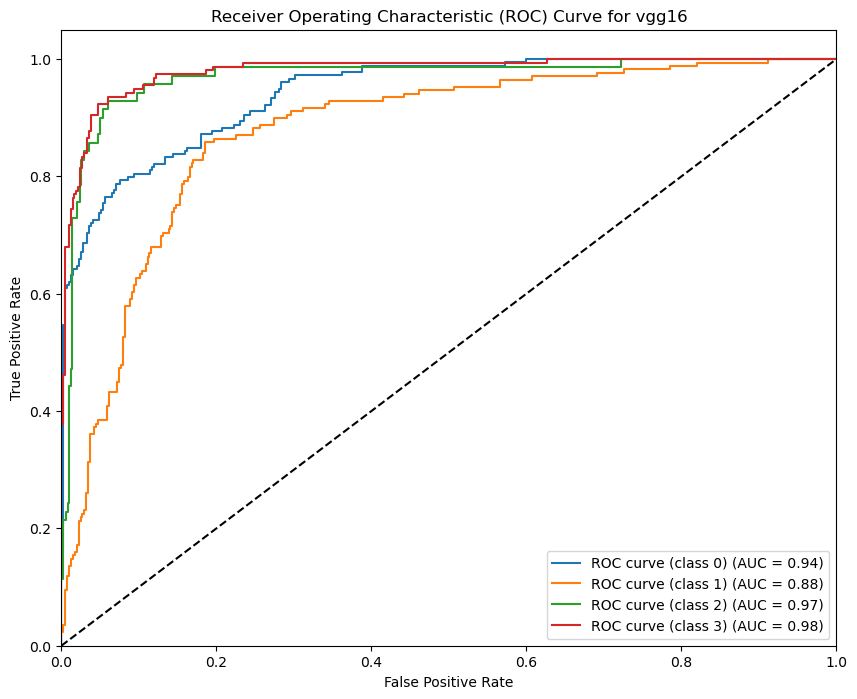

Epoch 1/10
36/36 [==============================] - 87s 2s/step - loss: 0.9976 - accuracy: 0.5945 - val_loss: 0.6471 - val_accuracy: 0.7631
Epoch 2/10
36/36 [==============================] - 65s 2s/step - loss: 0.6664 - accuracy: 0.7430 - val_loss: 0.5504 - val_accuracy: 0.7875
Epoch 3/10
36/36 [==============================] - 64s 2s/step - loss: 0.5830 - accuracy: 0.7679 - val_loss: 0.4876 - val_accuracy: 0.8153
Epoch 4/10
36/36 [==============================] - 67s 2s/step - loss: 0.4982 - accuracy: 0.8071 - val_loss: 0.4732 - val_accuracy: 0.8084
Epoch 5/10
36/36 [==============================] - 64s 2s/step - loss: 0.4685 - accuracy: 0.8171 - val_loss: 0.4236 - val_accuracy: 0.8310
Epoch 6/10
36/36 [==============================] - 64s 2s/step - loss: 0.4354 - accuracy: 0.8345 - val_loss: 0.4283 - val_accuracy: 0.8397
Epoch 7/10
36/36 [==============================] - 64s 2s/step - loss: 0.3874 - accuracy: 0.8606 - val_loss: 0.3993 - val_accuracy: 0.8571
Epoch 8/10
36/36 [==

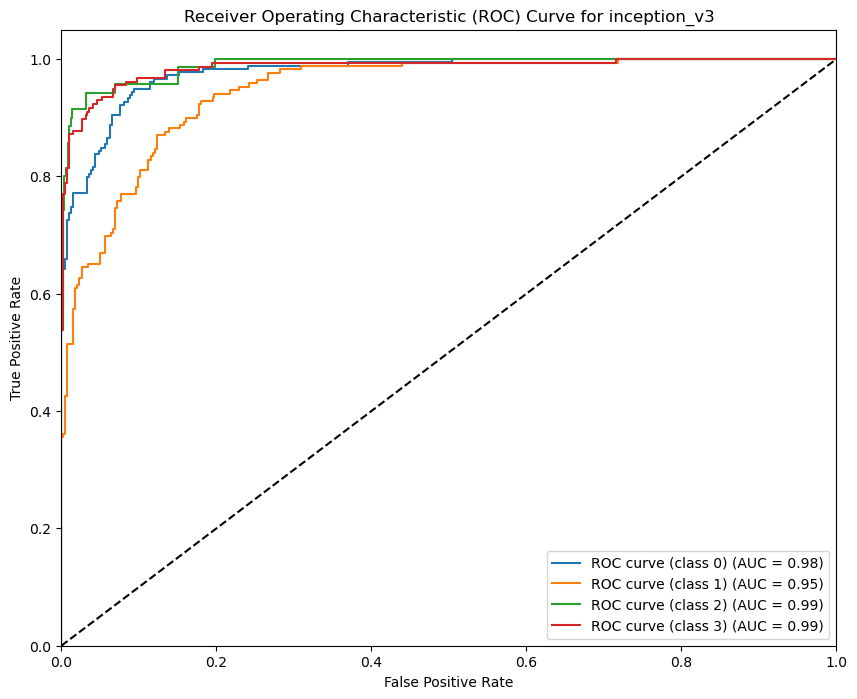

In [10]:
#3-pretrained models
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import label_binarize

def load_dataset(zip_file_path):
    # Extract ZIP file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('dataset')
    
    # Load images and labels
    images_dir = 'dataset/Brain-Tumor-Classification-DataSet-master'
    images = []
    labels = []
    categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
    
    for label, category in enumerate(categories):
        category_path = os.path.join(images_dir, 'Training', category)
        for file_name in os.listdir(category_path):
            img_path = os.path.join(category_path, file_name)
            img = load_img(img_path, target_size=(224, 224))  # Resize to fit pre-trained model
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    
    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    # One-hot encode labels (for multi-class classification)
    labels = to_categorical(labels, num_classes=len(categories))
    
    # Split dataset into training and testing sets
    trainX, testX, trainY, testY = train_test_split(images, labels, test_size=0.2, random_state=42)
    return trainX, trainY, testX, testY

# Load the dataset
zip_file_path = r"C:\Users\91817\Downloads\archive (15).zip"
trainX, trainY, testX, testY = load_dataset(zip_file_path)

# Normalize the images
trainX = trainX.astype('float32') / 255.0
testX = testX.astype('float32') / 255.0

# Function to build a model using a pre-trained architecture
def build_pretrained_model(base_model):
    # Freeze the base model layers
    base_model.trainable = False
    
    # Add new layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(4, activation='softmax')(x)  # 4 classes for brain tumor classification
    
    # Create the full model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Pre-trained models (ResNet50, VGG16, and InceptionV3)
pretrained_models = [
    ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
]

# Train and evaluate each pre-trained model
for base_model in pretrained_models:
    model = build_pretrained_model(base_model)
    
    # Train the model
    model.fit(trainX, trainY, epochs=10, batch_size=64, validation_data=(testX, testY))
    
    # Evaluate the model
    loss, accuracy = model.evaluate(testX, testY)
    print(f'{base_model.name} Test Accuracy: {accuracy * 100:.2f}%')
    
    # Classification Report
    testY_pred = np.argmax(model.predict(testX), axis=1)
    testY_true = np.argmax(testY, axis=1)
    print(f"\nClassification Report for {base_model.name}:\n", classification_report(testY_true, testY_pred))
    
    # ROC Curve
    fpr, tpr, roc_auc = {}, {}, {}
    testY_bin = label_binarize(testY_true, classes=[0, 1, 2, 3])
    
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(testY_bin[:, i], model.predict(testX)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(4):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:0.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {base_model.name}')
    plt.legend(loc="lower right")
    plt.show()






Epoch 1/10


36/36 [==============================] - 956s 26s/step - loss: 2.9423 - accuracy: 0.2792 - val_loss: 1.3613 - val_accuracy: 0.2718
Epoch 2/10
36/36 [==============================] - 896s 25s/step - loss: 1.3629 - accuracy: 0.3084 - val_loss: 1.3356 - val_accuracy: 0.3118
Epoch 3/10
36/36 [==============================] - 997s 28s/step - loss: 1.3509 - accuracy: 0.3010 - val_loss: 1.3203 - val_accuracy: 0.3118
Epoch 4/10
36/36 [==============================] - 891s 25s/step - loss: 1.3366 - accuracy: 0.3040 - val_loss: 1.3142 - val_accuracy: 0.3868
Epoch 5/10
36/36 [==============================] - 951s 26s/step - loss: 1.2771 - accuracy: 0.3693 - val_loss: 1.1974 - val_accuracy: 0.5627
Epoch 6/10
36/36 [==============================] - 931s 26s/step - loss: 1.2579 - accuracy: 0.3946 - val_loss: 1.1663 - val_accuracy: 0.4895
Epoch 7/10
36/36 [==============================] - 859s 24s/step - loss: 1.1348 - accuracy: 0.5074 - val_loss: 1.0484 - val_accuracy: 0.5192


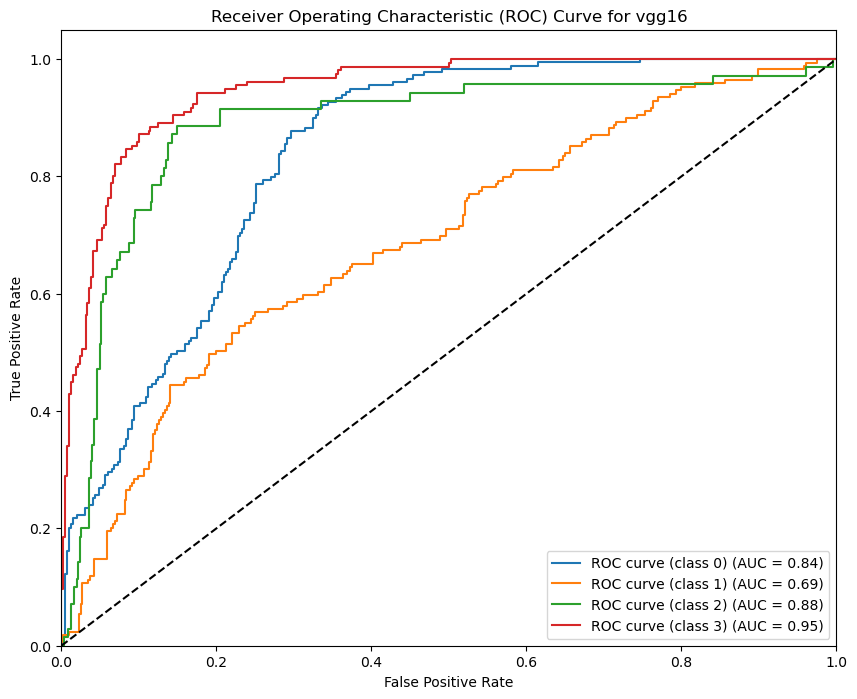

Epoch 1/10
15/36 [===========>..................] - ETA: 1:56 - loss: 1.2107 - accuracy: 0.5115

In [ ]:
#feature extraction from specific layer
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import label_binarize

def load_dataset(zip_file_path):
    # Extract ZIP file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('dataset')
    
    # Load images and labels
    images_dir = 'dataset/Brain-Tumor-Classification-DataSet-master'
    images = []
    labels = []
    categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
    
    for label, category in enumerate(categories):
        category_path = os.path.join(images_dir, 'Training', category)
        for file_name in os.listdir(category_path):
            img_path = os.path.join(category_path, file_name)
            img = load_img(img_path, target_size=(224, 224))  # Resize to fit pre-trained model
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    
    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    # One-hot encode labels (for multi-class classification)
    labels = to_categorical(labels, num_classes=len(categories))
    
    # Split dataset into training and testing sets
    trainX, testX, trainY, testY = train_test_split(images, labels, test_size=0.2, random_state=42)
    return trainX, trainY, testX, testY

# Load the dataset
zip_file_path = r"C:\Users\91817\Downloads\archive (15).zip"
trainX, trainY, testX, testY = load_dataset(zip_file_path)

# Normalize the images
trainX = trainX.astype('float32') / 255.0
testX = testX.astype('float32') / 255.0

# Function to build a model using a pre-trained architecture and extract features from a specific layer
def build_feature_extraction_model(base_model, layer_name):
    # Extract the output of the specified middle layer
    intermediate_layer = base_model.get_layer(layer_name).output
    
    # Add new layers on top of the extracted features
    x = GlobalAveragePooling2D()(intermediate_layer)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(4, activation='softmax')(x)  # 4 classes for brain tumor classification
    
    # Create the full model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Pre-trained models and the corresponding middle layers for feature extraction
pretrained_models = [
    (VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), 'block4_conv1'),
    (ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), 'conv4_block1_1_conv'),
    (InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), 'mixed7')
]

# Train and evaluate each pre-trained model
for base_model, layer_name in pretrained_models:
    model = build_feature_extraction_model(base_model, layer_name)
    
    # Train the model
    model.fit(trainX, trainY, epochs=10, batch_size=64, validation_data=(testX, testY))
    
    # Evaluate the model
    loss, accuracy = model.evaluate(testX, testY)
    print(f'{base_model.name} Test Accuracy: {accuracy * 100:.2f}%')
    
    # Classification Report
    testY_pred = np.argmax(model.predict(testX), axis=1)
    testY_true = np.argmax(testY, axis=1)
    print(f"\nClassification Report for {base_model.name}:\n", classification_report(testY_true, testY_pred))
    
    # ROC Curve
    fpr, tpr, roc_auc = {}, {}, {}
    testY_bin = label_binarize(testY_true, classes=[0, 1, 2, 3])
    
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(testY_bin[:, i], model.predict(testX)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(4):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:0.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {base_model.name}')
    plt.legend(loc="lower right")
    plt.show()
